In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [34]:
from src.serialization_lib import read_df_res_from_feather, read_df_debug_from_feather
from src.data_types import *
import pandas as pd
import statistics
import datetime

# pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_colwidth', 100)
pd.options.display.float_format = "{:,.2f}".format

In [35]:
INITIAL_PORTFOLIO_VALUE = 10000
PORTFOLIO_SIZE = 30
REBALANCE_DAYS = 90

BASE_METRIC = EvaluationMetric.EV_EBIT
TEST_METRIC = EvaluationMetric.P_B
STOCKS_UNIVERSE = StockUniverse.LARGE
PORTFOLIO_WEIGHT_STRATEGY = StockBasketWeightApproach.EQUAL_WEIGHTING

In [36]:
def plot_backtest(
    df: pd.DataFrame,
    base_metric: EvaluationMetric,
    test_metric: EvaluationMetric, 
    rebalance_days: int,
    portfolio_size: int,
    stocks_universe: StockUniverse
):
    df_to_plot = df[['base_price', 'test_price']]
    df_to_plot.plot(title=(
        f'{str(base_metric)} (base)'
        f' VS {str(test_metric)} (test)\n'
        f' Rebalance freq: {rebalance_days} days\n'
        f' Portfolio size: {portfolio_size} stocks\n'
        f' Universe of stocks: {str(stocks_universe)}'))

In [37]:
df_debug = read_df_debug_from_feather(REBALANCE_DAYS)
df_res = read_df_res_from_feather(REBALANCE_DAYS)

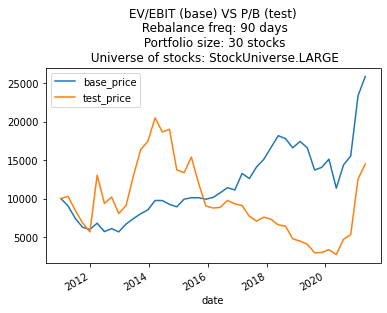

In [38]:
plot_backtest(df_res, BASE_METRIC, TEST_METRIC, REBALANCE_DAYS, PORTFOLIO_SIZE, STOCKS_UNIVERSE)

In [39]:
df_debug.iloc[0:5]

,prev_date,curr_date,base_portfolio_prev_price,base_portfolio_curr_price,base_portfolio_tickers_closed,base_portfolio_per_ticker_data,new_base_portfolio_per_ticker_data
date,,,,,,,
2011-04-01,2011-01-03,2011-04-01,"10,000.00","9,043.29",{},"[[ADGI, 3.3, 3.52], [AXGN, 4.0, 2.84], [BDSI, 3.55, 3.55], [BOPH, 1.79, 1.7], [CBFV, 12.056, 12....","[[ABAT, NA, 2.07], [ADGI, NA, 3.52], [ATV, NA, 17.662], [BOPH, NA, 1.7], [CAGM, NA, 0.66], [CBEH..."
2011-07-01,2011-04-01,2011-07-01,"9,043.29","7,401.58",{},"[[ABAT, 2.07, 1.07], [ADGI, 3.52, 3.5], [ATV, 17.662, 19.914], [BOPH, 1.7, 0.91], [CAGM, 0.66, 0...","[[ADGI, NA, 3.5], [BOPH, NA, 0.91], [BSPM, NA, 24.15], [CAGM, NA, 0.6], [CETC, NA, 47.8], [CMFB,..."
2011-09-30,2011-07-01,2011-09-30,"7,401.58","6,244.36",{ADGI},"[[ADGI, 3.5, 3.15], [BOPH, 0.91, 0.8], [BSPM, 24.15, 14.28], [CAGM, 0.6, 0.22], [CETC, 47.8, 31....","[[ABAT, NA, 1.01], [ASYS, NA, 8.0], [BERK, NA, 6.39], [BLRX, NA, 43.35], [BOPH, NA, 0.8], [BSET,..."
2011-12-29,2011-09-30,2011-12-29,"6,244.36","5,987.10",{},"[[ABAT, 1.01, 0.42], [ASYS, 8.0, 8.47], [BERK, 6.39, 7.2], [BLRX, 43.35, 47.55], [BOPH, 0.8, 0.4...","[[ASYS, NA, 8.47], [BLRX, NA, 47.55], [BSET, NA, 5.139], [CAAS, NA, 3.35], [CGA, NA, 32.451], [C..."
2012-03-28,2011-12-29,2012-03-28,"5,987.10","6,782.75",{},"[[ASYS, 8.47, 8.8], [BLRX, 47.55, 42.45], [BSET, 5.139, 6.467], [CAAS, 3.35, 6.309], [CGA, 32.45...","[[ASYS, NA, 8.8], [BSET, NA, 6.467], [CBPI, NA, 0.738], [CNEP, NA, 3.11], [CNGL, NA, 0.35], [CYB..."


In [40]:
df_res

,base_price,test_price,base_price_prev,test_price_prev
date,,,,
2011-01-03,"10,000.00","10,000.00",NaN,NaN
2011-04-01,"9,043.29","10,288.22","10,000.00","10,000.00"
2011-07-01,"7,401.58","8,456.43","9,043.29","10,288.22"
2011-09-30,"6,244.36","6,810.83","7,401.58","8,456.43"
2011-12-29,"5,987.10","5,649.32","6,244.36","6,810.83"
2012-03-28,"6,782.75","13,043.65","5,987.10","5,649.32"
2012-06-26,"5,691.74","9,357.97","6,782.75","13,043.65"
2012-09-24,"6,079.12","10,195.72","5,691.74","9,357.97"
2012-12-21,"5,657.01","8,051.29","6,079.12","10,195.72"


In [55]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html
def color_per_cell(v):
    per = float(v[:-1])
    if per < -25:
        return "background-color: orangered"
    elif per >= -25 and per < 0:
        return "background-color: #ffcccb"
    elif per >= 0 and per < 25:
        return "background-color: #90ee90"
    elif per >= 25:
        return "background-color: green"

def display_two_decimal_places(val):
    return f'${val:,.2f}'

def display_date_only(d):
    return d.strftime('%Y-%m-%d')

def tuple_array_to_df(tuple_arr):
    df = pd.DataFrame.from_records(tuple_arr, columns=['ticker', 'prev', 'curr'])
    df['ticker'] = df['ticker'].str.replace("'", "")
    return df

def per_stocks_up(tupple_arr):
    return f'{round(100 * sum([1 for (ticker, prev, curr) in tupple_arr if (curr > prev)]) / len(tupple_arr), 2)}%'

def p_change(r):
    return f'{round(100 * (r.base_portfolio_curr_price - r.base_portfolio_prev_price ) / r.base_portfolio_prev_price, 2)}%'

def p_change2(r):
    return f'{round(100 * (r.curr - r.prev ) / r.prev, 2)}%'

def get_date_based_df(df_debug, date):
    df_date = df_debug.loc[date]
    tuple_arr = df_date['base_portfolio_per_ticker_data']
    df = tuple_array_to_df(tuple_arr)
    tickers_closed = [str(s) for s in df_date['base_portfolio_tickers_closed']]
    df['up'] = df.apply(lambda r: r['curr'] > r['prev'], axis=1)
    df['per_change'] = df.apply(lambda r: p_change2(r), axis=1)
    df['did_close'] = df.apply(lambda r: "Closed" if str(r.ticker) in tickers_closed else "", axis=1)
    df = df.sort_values(by='per_change', key=lambda col: col.map(lambda v: float(v[:-1])))    
    summary_row = [
        'Summary / Total ',
        round(sum(df['prev']), 20),
        round(sum(df['curr']), 20),
        f"{round(100 * sum(df['up']) / len(df['up']))}%",
        f"{round(statistics.mean([float(p[:-1]) for p in df['per_change']]), 2)}%",
        ""
    ]
    df.loc[len(df.index)] = summary_row
    return df

df_debug['per_stock_up'] = df_debug.apply(lambda r: per_stocks_up(list(r.base_portfolio_per_ticker_data)), axis=1)
df_debug['portfolio_change'] = df_debug.apply(lambda r: p_change(r), axis=1)

df_debug_readable = df_debug.copy()
df_debug_readable['num_tickers_closed'] = df_debug_readable.apply(lambda r: len(r.base_portfolio_tickers_closed), axis=1)
df_debug_readable = df_debug.drop(['base_portfolio_tickers_closed', 'base_portfolio_per_ticker_data', 'new_base_portfolio_per_ticker_data'], axis=1)
df_debug_readable.rename(columns={'base_portfolio_prev_price': 'prev', 'base_portfolio_curr_price': 'curr'}, inplace=True)

date_to_inspect = df_debug.index[7]
df_date = get_date_based_df(df_debug, date_to_inspect)

In [56]:
df_debug_with_style = df_debug_readable.round(2).style \
    .format({
        'curr': display_two_decimal_places,
        'prev': display_two_decimal_places,
        'date': display_date_only,
        'prev_date': display_date_only,
        'curr_date': display_date_only,    
    })

df_debug_with_style.applymap(color_per_cell, subset=['per_stock_up', 'portfolio_change'])

,prev_date,curr_date,prev,curr,per_stock_up,portfolio_change
date,,,,,,
2011-04-01 00:00:00,2011-01-03,2011-04-01,"$10,000.00","$9,043.29",36.67%,-9.57%
2011-07-01 00:00:00,2011-04-01,2011-07-01,"$9,043.29","$7,401.58",33.33%,-18.15%
2011-09-30 00:00:00,2011-07-01,2011-09-30,"$7,401.58","$6,244.36",20.0%,-15.63%
2011-12-29 00:00:00,2011-09-30,2011-12-29,"$6,244.36","$5,987.10",46.67%,-4.12%
2012-03-28 00:00:00,2011-12-29,2012-03-28,"$5,987.10","$6,782.75",80.0%,13.29%
2012-06-26 00:00:00,2012-03-28,2012-06-26,"$6,782.75","$5,691.74",33.33%,-16.09%
2012-09-24 00:00:00,2012-06-26,2012-09-24,"$5,691.74","$6,079.12",60.0%,6.81%
2012-12-21 00:00:00,2012-09-24,2012-12-21,"$6,079.12","$5,657.01",33.33%,-6.94%
2013-03-22 00:00:00,2012-12-21,2013-03-22,"$5,657.01","$6,681.71",70.0%,18.11%


In [62]:
df_with_style = df_date.style \
    .format({
        'curr': display_two_decimal_places,
        'prev': display_two_decimal_places,
    })\.set_caption(f"Rebalance results on {datetime.datetime.strftime(date_to_inspect, '%Y-%m-%d')} for {str(STOCKS_UNIVERSE)}") \
    .set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-size', '16px'),
        ('text-align', 'center'),        
    ]
}])

df_with_style.applymap(color_per_cell, subset=['per_change'])

SyntaxError: unexpected character after line continuation character (<ipython-input-62-ad0944bae293>, line 5)